# FastAI
I am currently working through FastAI's MOOC released January 2019. Jeremy Howard continually indicates that you can get world class results in a few lines of code. I was admittedly skeptical, but working through a couple of lessons and applying the example code to a dataset of North American birds, I was able improve upon current state-of-the-art accuracy rate.

## Current State of the Art
The most current paper that I could find reporting state-of-the-art results on the NABirds dataset was published in arXiv September 2018. The current best results found in [Aligned to the Object, not to the Image: A Unified Pose-aligned Representation for Fine-grained Recognition](https://arxiv.org/pdf/1801.09057.pdf)​ got a 87.9% accuracy. Using the FastAI library for deep learning image processing I was able to attain 89.5% accuracy.

## Data
The data for this project is available from [The Cornell Lab of Ornithology](http://dl.allaboutbirds.org/nabird) ​and is a collection of 48,000 photos featuring 555 species of North America's birds.

In [1]:
%reload_ext autoreload
%autoreload 2

from fastai.vision import *

In [2]:
path = "data/nabirds/"
path

'data/nabirds/'

## Data Labels
I was unable to get FastAI to load the bird label using either csv or dataframe methods, despite speanding an entire day sifting through forums.fast.ai. I finally just created a name dictionary and relabelled all the image folders. No doubt that someone with the tiniest bit more experience could do this properly in 2 minutes.

Anyway the below code will change all the file names from the 4-digit code to the bird common name. This code only needs to run once.

In [ ]:
'''
import pandas as pd
labels = pd.read_csv('data/nabirds/images.txt', sep=" ", header=None)
labels.columns = ['jpg', 'jpg_w_class']
labels['category'] = labels['jpg_w_class'].str.split('/').str[0]
labels['jpg'] = labels['jpg_w_class'].str.split('/').str[1]
#labels['jpg'] = labels['jpg'].str.split('.').str[0]
#labels = labels.drop(['jpg_w_class'], axis=1)
labels.head()
'''

'''
classes = pd.read_table('data/nabirds/classes.txt', delimiter=None)
classes.columns = ['code']
classes[['class','common_name']] = classes['code'].str.split(" ", 1, expand=True)
classes = classes.drop(['code'], axis=1)
classes['class'] = classes['class'].str.zfill(4)
classes.head()
'''

'''
bird_label = pd.merge(labels, classes,  how='left', left_on=['category'], right_on = ['class'])
bird_label.reset_index(inplace=True)
bird_label.head()
'''

'''
bird_label['common_name'] = bird_label['common_name'].str.replace(r'[^\w\s]+', '')
bird_label.head()
'''

'''
d = {k: v for k, v in zip(bird_label['class'], bird_label.common_name)}

for folder in os.listdir(path):
    for folder in d:
        os.rename(os.path.join(path,folder), os.path.join(path,d[folder]))
'''

## Transforms and Data Loading
Currently using FastAI default settings to get a baseline result, except the batch size (bs) has been reduced to 32 to accomodate my GPU and the image size (size) to better accomodate the NABirds image size. In the future, I will fine-tune parameters to improve upon results.

In [3]:
np.random.seed(28)
tfms = get_transforms()
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=384)
        .databunch(bs=16))

In [4]:
data.to_df().head()

x              y
0  images\Aberts Towhee\03f70ef2c05649fb8e80243e9...  Aberts Towhee
1  images\Aberts Towhee\043ddb2171e647fe9c28dab8d...  Aberts Towhee
2  images\Aberts Towhee\103a31d3f2474c79a1e6c8905...  Aberts Towhee
3  images\Aberts Towhee\1182954c56ee463cbaab1dc65...  Aberts Towhee
4  images\Aberts Towhee\12cb9e8cf0a1449f86017e9a5...  Aberts Towhee

## View the Data
Currently the data labels are numbers and need to be compared with a text file (near future project to incorporate). Images appear to be importing fine and a spot check with the labels file and my amateur birding abilities the labels match the bird species.

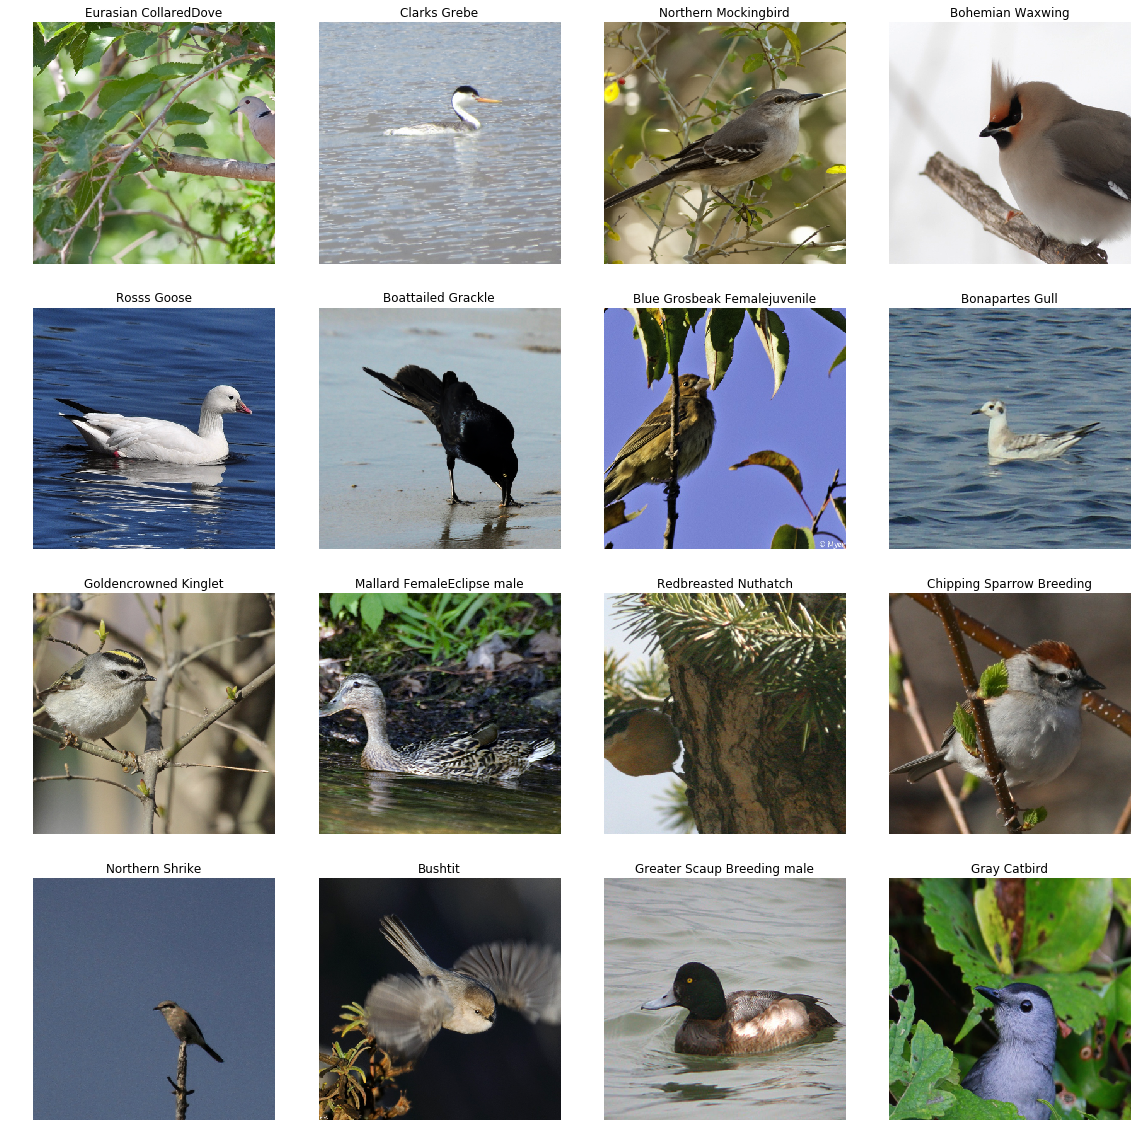

In [7]:
data.show_batch(rows=4)

## Model and Learning Rate

Again all FastAI default settings were used. Resnet34 backbone was used as an initial architecture. In the future will try the more complex resnet50 to investigate if improvements can be made.

In [5]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(4)

In [6]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


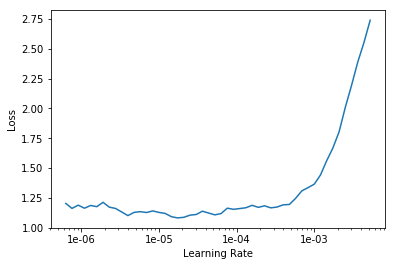

In [7]:
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(20, slice(1e-5,3e-4))

In [9]:
learn.save('stage-2')

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

## Prediction Results
Below are the top 9 worst predictions. There is a mix of species that are very similar and hard for humans to differentiate, poor image quality, and examples of proper species identification but incorrect male/female/immature or color phase identification.

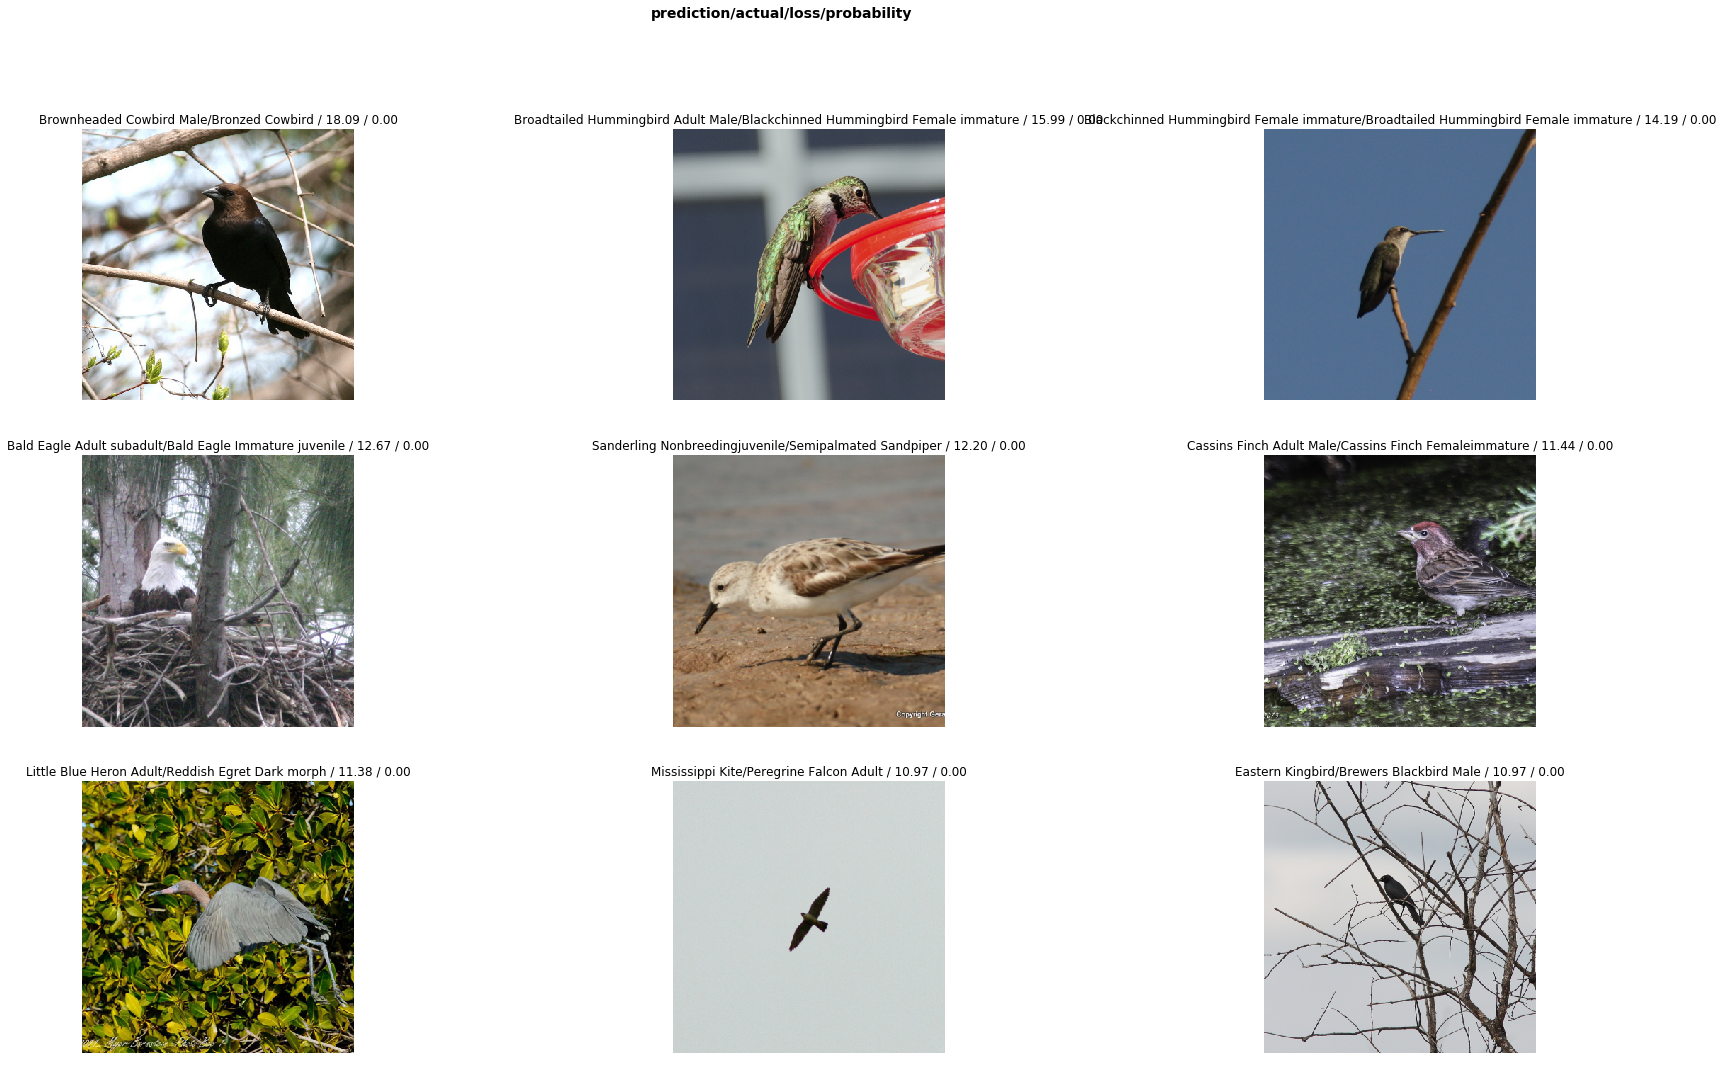

In [18]:
interp.plot_top_losses(9, figsize=(30,17))

## Conclusion and Future Work
Initial results are extemely promising and I am hoping that with some parameter fine-tuning to push the accuracy to 90% (attempt 1; 86.03%, attempt 2; 89.53%).

To Do:
- Load species name in a much cleaner manner
- Compare deep learning architectures (resnet34, resnet50, etc.)
- Fine-tune parameters and implement different image augmentation techniques
- Create a web app
- Apply this work to a real time bird feeder cam